# Feature Engineering
The purpose of this section is to label each post with all the stock tickers mentioned inside, to explore the ditribution of stock mentions and to preprocess natural language for sentiment analysis.

In [150]:
library(tidyverse);
library(quantmod);
library(tidyquant);
library(gridExtra);
library(ggplot2);

## Response variable creation: R50 index  
As we previously saw, not all the stocks have enough observations to cover the entire observed period, so, instead of deleting most of the tickers, we will create an index that will represent the meme stocks as a whole. To do this we will create an index based on the 50 most popular stocks on Robinhood in march 2021, the R50. 

This is because Robinhood played a key role in the meme stocks phenomenon, as it allowed retail traders to trader extremely risky instruments with very low transaction fees, so it was the main broker utilized by the commuity(in fact there is a large overlap with the 50 most mentioned stocks). Robinhood was also in the center of a massive discussion when it halted the trading of Gamestop stocks for multiple times, making it an anthagonist to the Wallstreetbets subreddit.

Note that some of the stocks included in the r50 are not listed anymore, but they are  included in the final calculations of r50.csv. 

In [151]:
# Read the CSV file "vader_sentiment.csv" into the wsb data frame
wsb <- read.csv(file = "../data/vader_sentiment.csv",
        header = TRUE,
        sep = ",",
        dec = ".")

# Parse the timestamp column as dates
wsb$timestamp <- parse_date(wsb$timestamp)

# Select timestamp, number of comments, number of upvotes and sentiment and remove duplicate rows
wsb <- wsb[c(5, 2, 4, 8)] %>% distinct()

# Define a list of the 50 most popular stocks on Robinhood in March 2021
r50 <- c("AAPL", "TSLA", "AMC", "SNDL", "F", "GE", "NIO",
        "MSFT", "DIS", "AMZN", "NOK", "GME", "ZOM",
        "AAL", "PLUG", "PFE", "ACB", "CCVI", "CCL", "GPRO", "DAL",
        "OGI", "PLTR", "SNAP", "CTRM", "BABA",
        "MRNA", "BAC", "NFLX", "BB", "CGC", "FCEL", "IDEX",
        "AMD", "TLRY", "META", "NCLH", "T", "GM",
        "SPCE", "UAL", "BA", "KO", "SBUX", "CRON", "WKHS")#"APHA", "NAKD", "TWTR", "ZNGA"

# Retrieve stock prices for r50 stocks
stocks <- r50 %>%
        tq_get(get = "stock.prices",
                from = "2021-01-27",
                to = "2021-08-16");


The weights of the stocks in the portfolio will be based on the number of mentions we calculated in data_processing.ipynb, in particular, we will model the weights using the mean and standard deviation of the number of mentions to model a log-normal distribution. Since the standard deviation is much larger than the mean we will log-transform the number of mentions.

We will then have the top 10 most mentioned stock to weight around 60% of the index.

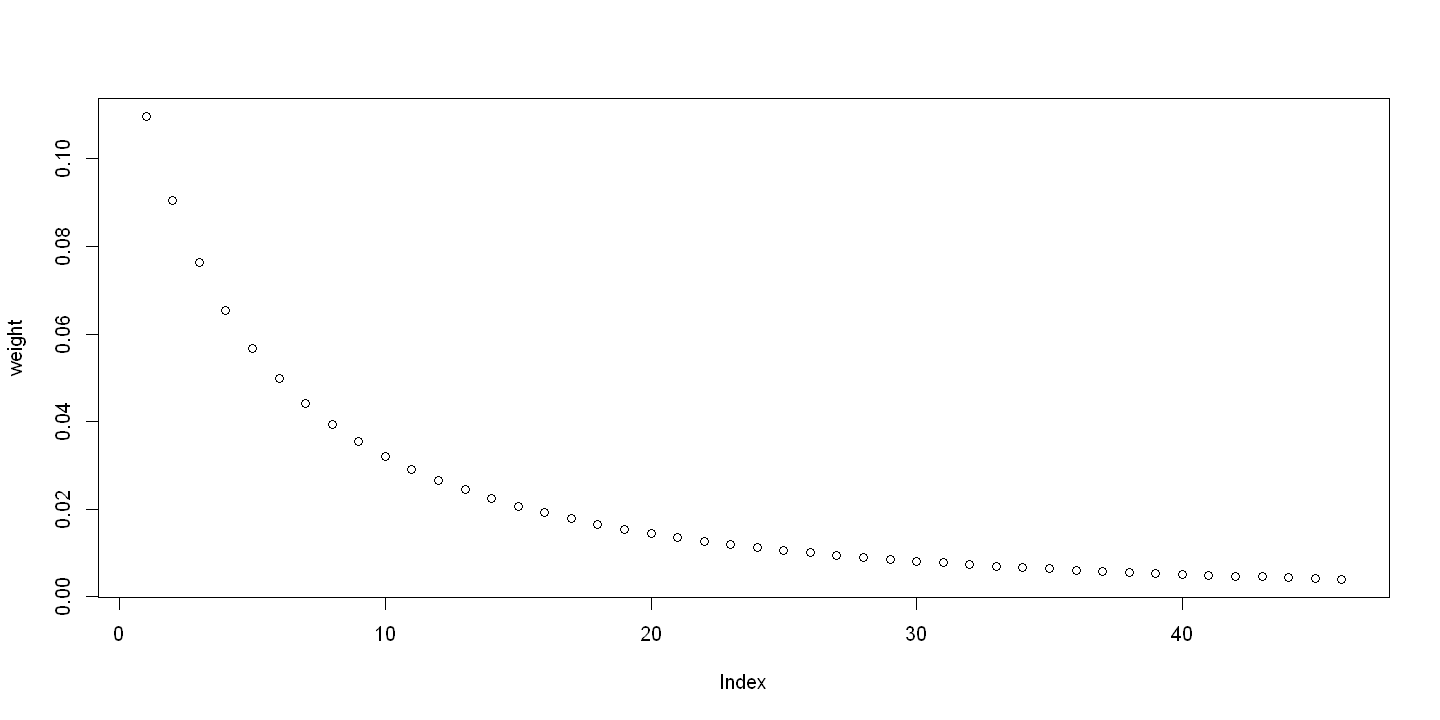

In [152]:
weight <- 1 - plnorm(rep(2:47), meanlog = 1.297974, sdlog =1.298812)
weight <- weight/sum(weight)
plot(weight)

# Create portfolio dataframe with r50 and weights
pfolio <- cbind(r50,weight) %>% as.data.frame()

The next step will be to create the r50 index by using the weights from the log normal distribution and the stock prices.
After gatherimg this data we will be able to compute the returns and the change in volume of the index.

In [153]:
# Add historical prices to each stock
stocks <- left_join(stocks, pfolio, by = c("symbol" = "r50"))
stocks$weight <- as.numeric(stocks$weight)

# Calculate r50 price and volume
stocks <- stocks %>%
        na.omit() %>%
        group_by(date) %>%
        summarise(
                r50_close = sum(close * weight),
                r50_volume = sum(volume * weight)
                )
# Calculate returns
stocks <- stocks %>%
        mutate(
                r = Delt(r50_close),                   # Arithmetic difference of the "close" column
                logr = Delt(r50_close, type = "log"),  # Logarithmic difference of the "close" column
                d_vol = Delt(r50_volume),              # Arithmetic difference of the "volume" column
                d_logvol = Delt(r50_volume, type = "log")  # Logarithmic difference of the "volume" column
        )

head(stocks)

date,r50_close,r50_volume,r,logr,d_vol,d_logvol
<date>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
2021-01-27,92.11809,202745137,NA,NA,NA,NA
2021-01-28,89.61655,141372098,-0.0271557173,-0.0275312479,-0.30271029,-0.36055431
2021-01-29,88.10543,123867862,-0.0168621013,-0.0170058852,-0.12381677,-0.13218004
2021-02-01,90.23816,103368344,0.0242065570,0.0239182221,-0.16549505,-0.18091660
2021-02-02,90.34202,97069839,0.0011509428,0.0011502810,-0.06093262,-0.06286805
2021-02-03,90.42393,70963356,0.0009066662,0.0009062555,-0.26894536,-0.31326708


## Adaptat sentiment to a daily time series and take engagement into account 

For sake of simplicity we will use data in daily timeframe, but if I will be able to gather hourly data I might expand the project to encorporate this change. So since we have a varying number of posts per day we will need to summarize the sentiment for each day. To do so we will calculate the daily sentiment average and variance. 

Following our sentiment analysis we saw a significant number of neutral posts, and given the large number of observations at our disposal we will get rid of the posts with a sentiment between -0.2 and 0.2.

In addition to that we will save the number of posts, comments and upvotes, which we will combine with sentiment to create a new feature to take into account the engagement of the post.  


In [154]:
# Assign sentiment values to each trading day
r50 <- full_join(wsb, stocks, by = c("timestamp" = "date"))

# Remove rows with missing values from r50
r50 <- r50 %>% na.omit()

# Filter r50 to include only rows with absolute sentiment value greater than 0.2
r50 <- r50 %>%
    filter(abs(sentiment) > 0.2) %>%
    na.omit()

head(r50)


,timestamp,score,comms_num,sentiment,r50_close,r50_volume,r,logr,d_vol,d_logvol
,<date>,<int>,<int>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
1,2021-01-28,0,47,-0.630,89.61655,141372098,-0.02715572,-0.02753125,-0.3027103,-0.3605543
2,2021-01-28,29,74,0.318,89.61655,141372098,-0.02715572,-0.02753125,-0.3027103,-0.3605543
3,2021-01-28,71,156,0.223,89.61655,141372098,-0.02715572,-0.02753125,-0.3027103,-0.3605543
4,2021-01-28,317,53,0.947,89.61655,141372098,-0.02715572,-0.02753125,-0.3027103,-0.3605543
5,2021-01-28,405,178,-0.991,89.61655,141372098,-0.02715572,-0.02753125,-0.3027103,-0.3605543
6,2021-01-28,200,161,0.361,89.61655,141372098,-0.02715572,-0.02753125,-0.3027103,-0.3605543


The upvote in reddit is comparable to the like in many other social media, and is a key indicator of engagement, just as the number of comments. These two variable are slightly correlated but some these values are clear outliers, so to reduce the variance of these features we will log transform the data. 

After the log transformation the two variables are highly correlated, so we will combine them together to avoid collinearity.

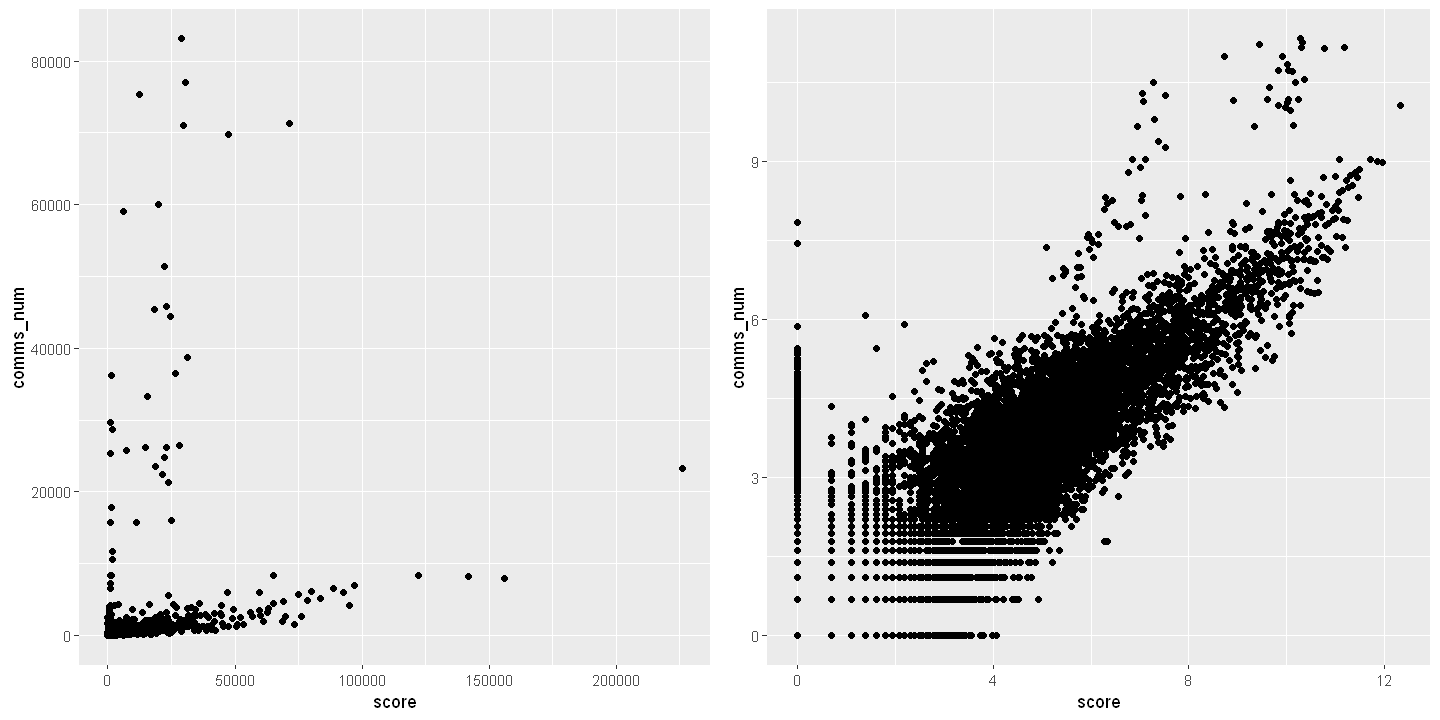

In [155]:
plot1 = ggplot(r50, aes(x = score, y = comms_num)) +
    geom_point()
# Log transform score and comms_num to reduce outliers impact
r50 <- r50 %>% 
    mutate(
        comms_num = log(comms_num),
        score = log(score)
    ) %>%
    mutate(
        comms_num = replace(comms_num, is.infinite(comms_num), 0),
        score = replace(score, is.infinite(score), 0)
        )


plot2 = ggplot(r50, aes(x = score, y = comms_num)) +
    geom_point()

options(repr.plot.width = 12, repr.plot.height = 6)
grid.arrange(plot1, plot2, ncol = 2)

# Combine score and comms_num into a new feature
r50$engagement = r50$score * r50$comms_num

# Remove score and comms_num
r50 <- select(r50,-c(comms_num, score))

Now that we have calculated post engagement we can fit our observations into a daily timeframe. To do so we will collect the average and the variance of each dependent variable. 

Another think we will do is to create a new feature to capture the weighted sentiment by engagement. 

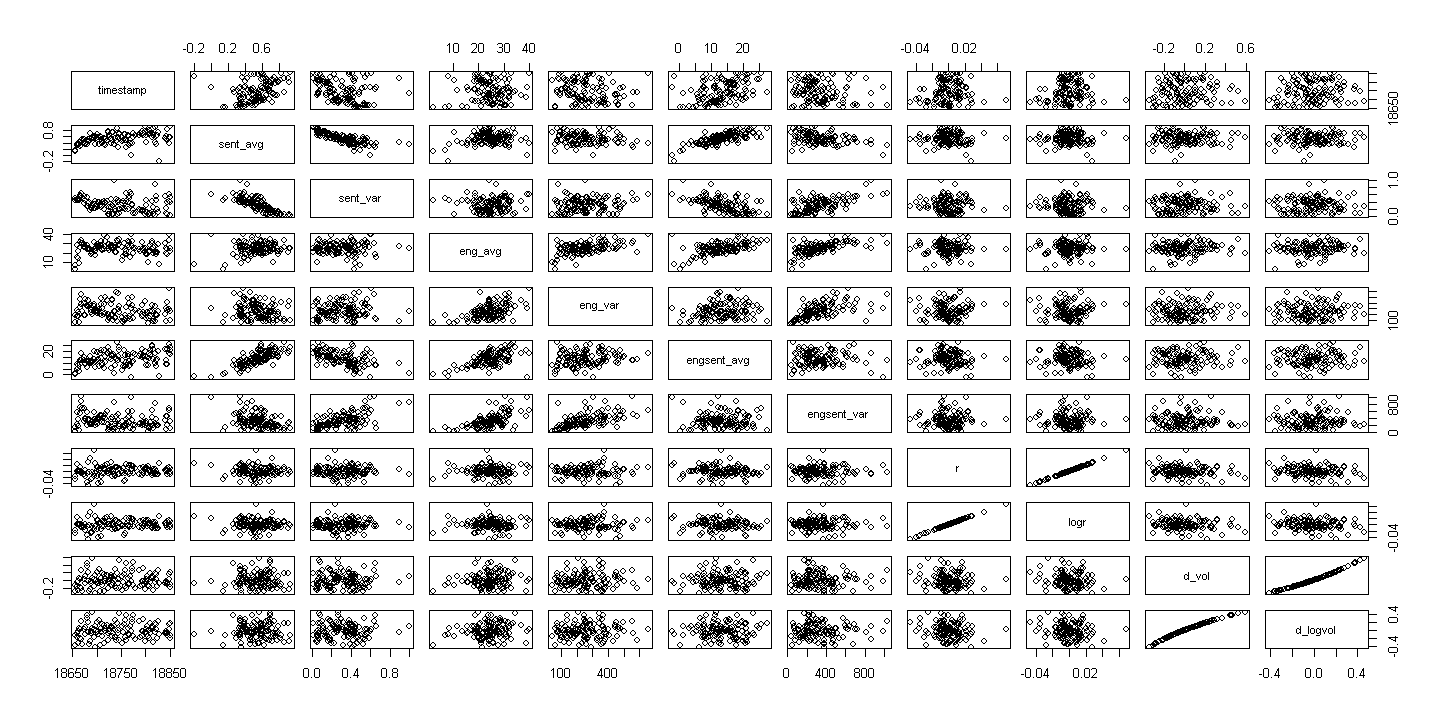

In [156]:
# Summaries variables for each trading day
r50 <- r50 %>%
    group_by(timestamp) %>%
    summarise(
            sent_avg = mean(sentiment),
            sent_var = var(sentiment),
            eng_avg = mean(engagement),
            eng_var = var(engagement),
            engsent_avg = mean(sentiment * engagement),
            engsent_var = var(sentiment * engagement),
            r = mean(r),
            logr = mean(logr),
            d_vol = mean(d_vol),
            d_logvol = mean(d_logvol))

plot(r50)